# Market Based Model - Recommendation

The objective of this notebook is to recommend recipes by matching the about-to-expire products from a specific cluster to our dataset of recipes. This process is conducted on a per-cluster basis, representing each food bank individually. As a result, each food bank receives tailored recommendations based on the items nearing expiration within its cluster and the predefined threshold criteria.

To ensure clarity and facilitate understanding, we have included detailed comments throughout the notebook, explaining the steps and decisions made at each stage.

## Dependencies

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import re

## Importing and Loading data

In [41]:
df = pd.read_pickle('data\salling_data.pkl')

df.head()

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\afons\AppData\Local\Temp\ipykernel_38228\1709852540.py:1: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_pickle('data\salling_data.pkl')


,Cleaned Ingredients,Store id,Store Name,Store Address,Store City,Store Zip,Store Brand,Description,EAN,Categories (da),...,Currency,Original Price,New Price,Discount,Percent Discount,Start Time,End Time,Stock,Stock Unit,cluster_id
0,dinner meal,efba0457-090e-4132-81ba-c72b4c8e7fee,Bilka Tilst,Agerøvej 7,Tilst,8381,bilka,GODT BEGYNDT,250280,Mejeri & køl>Færdigretter>Middagsretter,...,DKK,99.00,80.00,19.00,19.19,2024-11-23T08:36:28.000Z,2024-11-24T22:59:59.000Z,2.554,kg,0
1,pork,efba0457-090e-4132-81ba-c72b4c8e7fee,Bilka Tilst,Agerøvej 7,Tilst,8381,bilka,PORCHETTA SLGATERMESTE,250640,Kød & fisk>Grisekød>Stege & hele kødstykker>Fl...,...,DKK,149.00,55.00,94.00,63.09,2024-11-24T12:09:08.000Z,2024-11-25T22:59:59.000Z,2.554,kg,0
2,pork,efba0457-090e-4132-81ba-c72b4c8e7fee,Bilka Tilst,Agerøvej 7,Tilst,8381,bilka,SYLTEPAKKE SLAGTEREN,251265,Kød & fisk>Grisekød>Andet grisekød,...,DKK,89.00,49.00,40.00,44.94,2024-11-24T12:19:34.000Z,2024-11-25T22:59:59.000Z,5.298,kg,0
3,pork chop pork schnitzel,efba0457-090e-4132-81ba-c72b4c8e7fee,Bilka Tilst,Agerøvej 7,Tilst,8381,bilka,SKAFTEKOTELETTE BETJENTDISK,251397,"Kød & fisk>Grisekød>Koteletter, flæsk & schnit...",...,DKK,135.00,53.95,81.05,60.04,2024-11-24T12:02:16.000Z,2024-11-25T22:59:59.000Z,8.674,kg,0
4,salami,efba0457-090e-4132-81ba-c72b4c8e7fee,Bilka Tilst,Agerøvej 7,Tilst,8381,bilka,KÅLPØLSE PØLSEMAGERI,251595,Mejeri & køl>Pålæg>Kødpålæg>Spegepølse,...,DKK,49.95,40.00,9.95,19.92,2024-11-21T11:07:47.000Z,2024-11-25T22:59:59.000Z,4.754,kg,0


In [42]:
df.columns

Index(['Cleaned Ingredients', 'Store id', 'Store Name', 'Store Address',
       'Store City', 'Store Zip', 'Store Brand', 'Description', 'EAN',
       'Categories (da)', 'Categories (en)', 'Category 1', 'Category 2',
       'Category 3', 'Category 4', 'Image', 'Currency', 'Original Price',
       'New Price', 'Discount', 'Percent Discount', 'Start Time', 'End Time',
       'Stock', 'Stock Unit', 'cluster_id'],
      dtype='object')

In [43]:
recipes_df = pd.read_csv("data/recipes_data.csv")
recipes_df.head()

,id,source,link,title,description
0,1,bbc,https://www.bbc.co.uk/food/recipes/chicken_and...,Chicken and tomato pasta,olive oil
1,1,bbc,https://www.bbc.co.uk/food/recipes/chicken_and...,Chicken and tomato pasta,chicken breasts
2,1,bbc,https://www.bbc.co.uk/food/recipes/chicken_and...,Chicken and tomato pasta,butter
3,1,bbc,https://www.bbc.co.uk/food/recipes/chicken_and...,Chicken and tomato pasta,garlic
4,1,bbc,https://www.bbc.co.uk/food/recipes/chicken_and...,Chicken and tomato pasta,rosemary


To better fit our needs for this part, we restructured the recipes DataFrame. Specifically, we renamed the description column to **product_list** after grouping all products by the recipe id. Since the recipe title is consistent for each id, we easily extracted it during the grouping process. This reorganization ensures clarity and improves usability for subsequent analysis and recommendations.

In [44]:
recipes_reworked_df = recipes_df.groupby("id").agg({
    "description": list, 
    "title": "first"  
}).reset_index()


recipes_reworked_df.rename(columns={"description": "product_list"}, inplace=True)

recipes_reworked_df.head()

,id,product_list,title
0,1,"[olive oil, chicken breasts, butter, garlic, r...",Chicken and tomato pasta
1,2,"[peas, garlic, basil, pine nuts, Parmesan, oli...",Pea-sto pasta
2,3,"[penne, butter, olive oil, leek, spring onions...",Salmon pasta
3,4,"[hake, fennel, garlic, chilli, cherry tomatoes...","Acqua pazza with hake, fennel and tomatoes"
4,5,"[onions, carrots, olive oil, tomatoes, bay lea...",Adaptable bean soup


Similarly to the previous situation, to streamline the process and facilitate the matching between expired products and recipes, we renamed the column containing the products to **product_list**. Additionally, we grouped the data by cluster_id, allowing for easier filtering and analysis in subsequent steps.

In [45]:
grouped_products_df = df.groupby("cluster_id")["Cleaned Ingredients"].apply(list).reset_index()

# Rename columns for clarity
grouped_products_df.rename(columns={"Cleaned Ingredients": "product_list"}, inplace=True)

grouped_products_df.head()

,cluster_id,product_list
0,0,"[dinner meal, pork, pork, pork chop pork schni..."
1,1,"[dinner meal, pork tenderloin, dinner meal, po..."
2,2,"[salami, sausage, salami, pork sausage, sausag..."
3,3,"[pork, pork chop pork schnitzel, dinner meal, ..."
4,4,"[pork, pork, pork, pork neck pork loin, pork c..."


## Cleaning the product list

One of the main challenges we encountered during the matching process was the significant mismatch between items from the recipes (which were more directly retrieved from the API) and the items from the clustered products. This mismatch was a result of the extensive data transformation processes, including changes, merges, joins, and even translations.

Additionally, the clustered product data contained what we deemed to be a considerable amount of noise, such as duplicates, plural forms, and other slight variations. These inconsistencies made the matching process more complex and required additional data cleaning and standardization efforts to improve compatibility.

In [46]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\afons\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\afons\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

To address these challenges, we utilized the NLTK package, a tool commonly used in natural language processing tasks, to standardize our products. This involved several steps: removing duplicates, eliminating unnecessary words, converting text to lowercase, removing special characters, and lemmatizing the words to reduce them to their base form. These transformations significantly improved consistency and made matching products between datasets more efficient and accurate

In [47]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def general_standardize_ingredients(product_list):
    if not isinstance(product_list, list):
        return []
    product_list = list(set(product_list))

    standardized_list = []
    for ingredient in product_list:
        if pd.isna(ingredient):
            continue

        ingredient = ingredient.lower()

        ingredient = re.sub(r"[^\w\s]", "", ingredient)
        ingredient = re.sub(r"\d+", "", ingredient)
        ingredient = ingredient.strip()

        tokens = ingredient.split()
        tokens = [word for word in tokens if word not in stop_words]

        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        clean_ingredient = " ".join(tokens)

        if clean_ingredient:
            standardized_list.append(clean_ingredient)

    return sorted(set(standardized_list))

In [48]:
recipes_reworked_df["product_list"] = recipes_reworked_df["product_list"].apply(general_standardize_ingredients)
recipes_reworked_df.head()

,id,product_list,title
0,1,"[basil, black pepper, butter, cherry tomato, c...",Chicken and tomato pasta
1,2,"[basil, black pepper, chicken breast, garlic, ...",Pea-sto pasta
2,3,"[black pepper, butter, crème fraîche, leek, le...",Salmon pasta
3,4,"[cherry tomato, chilli, clam, fennel, garlic, ...","Acqua pazza with hake, fennel and tomatoes"
4,5,"[bay leaf, black pepper, cannellini bean, carr...",Adaptable bean soup


In [49]:
grouped_products_df["product_list"] = grouped_products_df["product_list"].apply(general_standardize_ingredients)
grouped_products_df.head()

,cluster_id,product_list
0,0,"[attachment, beef, beef sausage, buttermilk, c..."
1,1,"[attachment, bacon, beef, beef sausage, blue c..."
2,2,"[attachment, bacon, bacon bit, beef, beef saus..."
3,3,"[apple juice, attachment, bacon, beef, beef sa..."
4,4,"[attachment, bacon, beef sausage, blue cheese ..."


## Matching Products

In [50]:
def match_recipes(grouped_products_df, recipes_reworked_df):
    transactions = []
    for _, cluster_row in grouped_products_df.iterrows():
        cluster_id = cluster_row["cluster_id"]
        expired_products = set(cluster_row["product_list"])
        
        # Find matching recipes
        for _, recipe_row in recipes_reworked_df.iterrows():
            recipe_ingredients = set(recipe_row["product_list"])
            if expired_products & recipe_ingredients:  # Intersection of products
                transactions.append(list(recipe_ingredients))
    
    return transactions

In [51]:

transactions = match_recipes(grouped_products_df, recipes_reworked_df)
transactions = [[str(item) for item in transaction] for transaction in transactions]

In [52]:
# Convert transactions into a one-hot encoded DataFrame
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
transaction_df = pd.DataFrame(te_ary, columns=te.columns_)

Applying Apriori algorithm to find frequent itemsets and generating rules on a general rule

In [53]:

frequent_itemsets = apriori(transaction_df, min_support=0.2, use_colnames=True)
print(frequent_itemsets)

     support               itemsets
0   0.259536         (black pepper)
1   0.635095               (butter)
2   0.314017                  (egg)
3   0.254397               (garlic)
4   0.345185                 (milk)
5   0.212241            (olive oil)
6   0.220723                (onion)
7   0.241613          (plain flour)
8   0.346396                 (salt)
9   0.213370          (egg, butter)
10  0.204345         (butter, milk)
11  0.200668  (butter, plain flour)
12  0.223773         (salt, butter)


In [54]:

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
print(rules)

     antecedents    consequents  antecedent support  consequent support  \
0          (egg)       (butter)            0.314017            0.635095   
1       (butter)          (egg)            0.635095            0.314017   
2       (butter)  (plain flour)            0.635095            0.241613   
3  (plain flour)       (butter)            0.241613            0.635095   
4         (salt)       (butter)            0.346396            0.635095   
5       (butter)         (salt)            0.635095            0.346396   

    support  confidence      lift  leverage  conviction  zhangs_metric  
0  0.213370    0.679484  1.069893  0.013939    1.138491       0.095231  
1  0.213370    0.335965  1.069893  0.013939    1.033052       0.179025  
2  0.200668    0.315966  1.307738  0.047221    1.108698       0.644882  
3  0.200668    0.830538  1.307738  0.047221    2.153312       0.310291  
4  0.223773    0.646002  1.017173  0.003778    1.030810       0.025831  
5  0.223773    0.352345  1.017173  0

In [ ]:
def match_expired_to_recipes(cluster_id, stores_df, recipes_df):
    cluster_stores = stores_df[stores_df["cluster_id"] == cluster_id]

    expired_products = [
        product
        for products in cluster_stores["product_list"]
        for product in products
    ]

    common_items = []
    for _, recipe_row in recipes_df.iterrows():
        recipe_ingredients = recipe_row["product_list"]
        common_items.extend([item for item in recipe_ingredients if item in expired_products])

    common_items_df = pd.DataFrame(common_items, columns=["product"])
    common_counts = common_items_df.value_counts().reset_index()
    common_counts.columns = ["product", "count"]

    return common_counts

In [56]:
common_items_df = match_expired_to_recipes(1, grouped_products_df, recipes_reworked_df)

In [57]:
top_common_items = common_items_df.head(15)
print(top_common_items)

            product  count
0            butter    367
1              milk    166
2            potato     54
3           yoghurt     42
4             bacon     34
5      cream cheese     17
6           sausage     14
7           chicken     12
8             pasta     10
9            cheese      9
10  pork tenderloin      8
11             pork      7
12            cream      7
13   cottage cheese      5
14     pork sausage      5


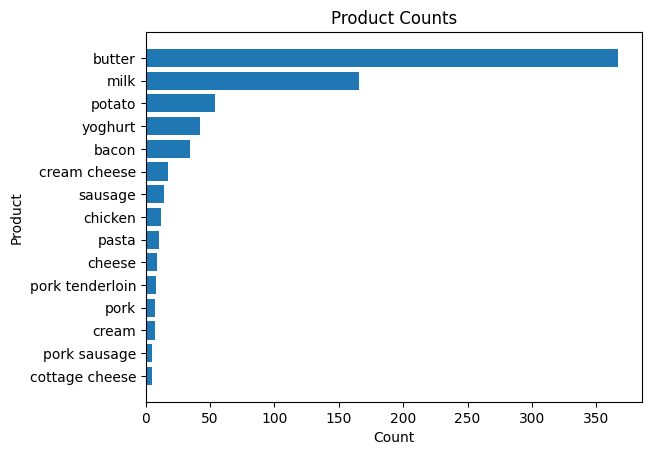

In [ ]:
fig, ax1 = plt.subplots()

df_sorted = top_common_items.sort_values("count", ascending=True)

plt.barh(df_sorted["product"], df_sorted["count"])
plt.xlabel("Count")
plt.ylabel("Product")
plt.title("Product Counts")
plt.show()

### Market Based Analysis

The Market-Based Analysis function is designed to match the product list from recipes with the about-to-expire items within a cluster. The process is structured as:
1. Filter for the Selected Cluster:
    - Focus on a specific cluster by isolating its data.
2. Retrieve Expired Products for the Cluster:
    - Collect all items nearing expiration for the cluster.
3. Clean Expired Product Data:
    - Address data noise by removing unnecessary or duplicated words, ensuring consistency.
4. Standardize Recipe Ingredients:
    - Match the cleaned expired products with standardized recipe ingredients for compatibility.
5. Filter Relevant Recipes:
    - Identify recipes containing at least one ingredient from the expired product list of the cluster.
6. Combine Data:
    - Merge the expired product list with recipe ingredients to focus on items relevant to the cluster.
7. Apply Apriori Algorithm:
    - Transform the data (using one-hot encoding) to run the Apriori Algorithm, which identifies frequent itemsets.

The analysis reveals the popular items among recipes sold in the cluster. This allows us to recommend recipes that align with the cluster’s expiring inventory.

In [59]:
def market_based_analysis(cluster_id, expired, recipes, min_support=0.1):
    cluster_stores = expired[expired["cluster_id"] == cluster_id]
    
    cluster_expired_products = []
    for product_list in cluster_stores["product_list"]:
        cluster_expired_products.extend(product_list)
    
    cluster_expired_products = sorted(set(cluster_expired_products))
    
    recipes["product_list"] = recipes["product_list"].apply(general_standardize_ingredients)
    
    relevant_recipes = recipes[recipes["product_list"].apply(
        lambda x: any(item in cluster_expired_products for item in x)
    )]
    
    
    transactions = []
    for product_list in relevant_recipes["product_list"]:
        filtered_items = [item for item in product_list if item in cluster_expired_products]
        if filtered_items:
            transactions.append(filtered_items)

    
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    transaction_df = pd.DataFrame(te_ary, columns=te.columns_)
    
    frequent_itemsets = apriori(transaction_df, min_support=min_support, use_colnames=True)
    
    if frequent_itemsets.empty:
        print("No frequent itemsets found.")
        return [], []
    else:
        frequent_itemsets["is_in_cluster"] = frequent_itemsets["itemsets"].apply(
            lambda x: all(item in cluster_expired_products for item in x)
        )
        cluster_itemsets = frequent_itemsets[frequent_itemsets["is_in_cluster"]]
        
        rules = association_rules(cluster_itemsets, metric="lift", min_threshold=1.0)
        
        return cluster_itemsets, rules



In [ ]:
cluster_id = 1
frequent_itemsets, rules = market_based_analysis(cluster_id, grouped_products_df, recipes_reworked_df, min_support=0.01)

print(frequent_itemsets)

     support                itemsets  is_in_cluster
0   0.061372                 (bacon)           True
1   0.662455                (butter)           True
2   0.016245                (cheese)           True
3   0.021661               (chicken)           True
4   0.012635                 (cream)           True
5   0.030686          (cream cheese)           True
6   0.299639                  (milk)           True
7   0.018051                 (pasta)           True
8   0.012635                  (pork)           True
9   0.014440       (pork tenderloin)           True
10  0.097473                (potato)           True
11  0.025271               (sausage)           True
12  0.075812               (yoghurt)           True
13  0.025271         (butter, bacon)           True
14  0.012635           (milk, bacon)           True
15  0.010830         (potato, bacon)           True
16  0.010830         (butter, cream)           True
17  0.018051  (butter, cream cheese)           True
18  0.175090

To showcase diverse recipe possibilities, we created a function that fetches recipes, using frequent itemsets identified by the Apriori Algorithm, and then display the result.

This approach bridges the gap between expiring inventory and popular recipes, providing a practical solution to reduce waste and enhance usability for the food bank.

In [80]:
def find_recipes(frequent_itemsets, recipes, min_items=1):
    itemsets = frequent_itemsets["itemsets"].tolist()

    matching_recipes = []

    for itemset in itemsets:
        # Filter itemsets based on the minimum number of items
        if len(itemset) >= min_items:
            matching = recipes[recipes["product_list"].apply(
                lambda x: set(itemset).issubset(set(x))
            )]

            matching_recipes.append({"itemset": itemset, "recipes": matching})

    return matching_recipes


In [81]:
matching_recipes = find_recipes(frequent_itemsets, recipes_reworked_df, 2)

for match in matching_recipes:
    itemset = match["itemset"]
    recipes_with_itemset = match["recipes"]

    print(f"\nSuggested recipes with: {', '.join(itemset)}")
    print("Matching Recipe Titles:")
    
    for title in recipes_with_itemset["title"]:
        print(f"- {title}")


Suggested recipes with: butter, bacon
Matching Recipe Titles:
- Gala picnic pie
- Gammon with treacle bacon crust
- Kale, squash and bacon pie
- Old fashioned rabbit stew
- Quiche Lorraine
- Valle d’Aosta cabbage soup
- Veal chop Normande
- Waffles with smoked bacon and caramelised peach
- The Ulster fry
- Posh jacket potatoes
- Chicken and red wine casserole
- Creamy Cowboy Soup Recipe
- Ultimate Twice-Baked Potatoes Recipe
- Creamy Cowboy Soup Recipe

Suggested recipes with: milk, bacon
Matching Recipe Titles:
- Bacon and asparagus flan
- Quiche Lorraine
- Waffles with smoked bacon and caramelised peach
- Posh jacket potatoes
- One Pan Pasta with Bacon and Peas Recipe
- Ultimate Twice-Baked Potatoes Recipe
- One Pan Pasta with Bacon and Peas Recipe

Suggested recipes with: potato, bacon
Matching Recipe Titles:
- Mackerel and bacon salad
- Tidy Friday pan fry
- Microwave jacket potatoes with various toppings
- Posh jacket potatoes
- Creamy Cowboy Soup Recipe
- Creamy Cowboy Soup Reci